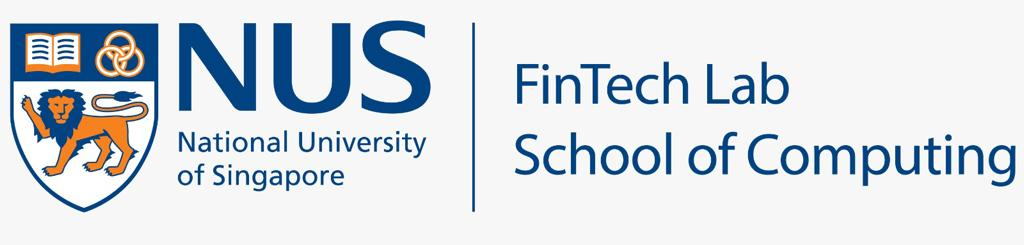

---

<font size="8">**IS5006 - Activity 2**</font>

# Objective

- To use HitBTC APIs to get ETH datastore 
- Store it in a google sheet
- Calculate moving averages
- Derive trade signals

## Student Details

- Name: AGRAWAL Shubhankar
- Student Id: A0248330L

## Key Points

- Ticker: ETHUSDT
- Period of evaluation: 01 Jan 2020 - Present
  - We collect data from 2018 to facilitate moving averages to eliminate NAs
- Frequency of data: Daily

# Libraries and Config

## Import libraries

In [1]:
# Import libraries to save the data from hitBTC to dataframe
import numpy as np
import pandas as pd
import requests
import json

import itertools
import datetime
import matplotlib.pyplot as plt

In [2]:
# Import libraries for google credentials
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials as GC
from gspread_dataframe import set_with_dataframe

## Config

In [3]:
# Increase plot size for larger plot
plt.rcParams['figure.figsize'] = [10, 5]

# Set a consistent workbook name
gs_title = 'IS5006-A0248330L'

# HitBTC API Limit to max
hitbtc_limit = 1000

# Helper functions

## Call HitBTC using APIs

In [4]:
def getDataHitbtc(symbol, period, since, to):

  # URL to get candlestick prices
  url = "https://api.hitbtc.com/api/3/public/candles/"+symbol

  # Calculate number of periods
  num_periods = (datetime.datetime.strptime(to, '%d-%m-%Y')-datetime.datetime.strptime(since, '%d-%m-%Y')).days 
  
  # Create empty dataframe
  df = pd.DataFrame(columns=['timestamp','open','close','min','max','volume','volumeQuote'])

  # Send multiple requests if periods larger than api limit
  for i in range((num_periods//hitbtc_limit)+1):
    payload = {'period': period,'from':since, 'till':to, 'limit': hitbtc_limit, 'offset': (i*hitbtc_limit), 'sort': 'ASC' }

    response = requests.get(url, payload)
    json_data = json.loads(response.text) 

    # Save the data to a dataframe
    temp_df = pd.DataFrame(json_data,columns=['timestamp','open','close','min','max','volume','volumeQuote'])
    df = df.append(temp_df)

  # Return df
  return df

## Dataframe to Google Sheets

In [5]:
def saveToGS(df, write_sheet) :
  # Authenticate
  auth.authenticate_user()

  # Authorise google credentials
  gc = gspread.authorize(GC.get_application_default())

  # Create, and save df
  sheet = None
  try:
    new_sheet = gc.open(gs_title)
  except: #if not exists
    print("Creating new sheet...")
    new_sheet = gc.create(gs_title)
  try:
    new_sheet.add_worksheet(title=write_sheet, rows=df.shape[0]+1, cols=df.shape[1]+1)
  except:
    pass
  sheet = gc.open(gs_title).worksheet(write_sheet)
  set_with_dataframe(sheet, df)

# Collect Data from API

Collect data for ETHUSDT from HitBTC API and saving raw data to Google Sheets

## Variables

Defining variables to collect data from HitBTC.

In [6]:
symbol = "ETHUSDT"
since = '01-11-2018' # To have moving average data from 2020, we require some values from previously
to = datetime.datetime.today().strftime('%d-%m-%Y')
period = "D1" # Daily periodic frequency

## Data Collection

Call API to collect data and save raw data to a google sheet

In [7]:
#save the data to a dataframe
df_GS = getDataHitbtc(symbol, period, since, to)

#save the dataframe to google sheets
saveToGS(df_GS, 'raw_values')

#view dataframe
df_GS.head()

,timestamp,open,close,min,max,volume,volumeQuote
0,2018-11-01T00:00:00.000Z,198.79,199.85,198.06,200.75,49207.045,NaN
1,2018-11-02T00:00:00.000Z,199.87,202.29,199.65,203.78,53989.115,NaN
2,2018-11-03T00:00:00.000Z,202.32,200.32,199.3,202.6,47258.614,NaN
3,2018-11-04T00:00:00.000Z,200.36,211.86,198.78,218.6,67840.131,NaN
4,2018-11-05T00:00:00.000Z,211.84,210.55,207.74,213.14,62479.027,NaN


Create a copy of the dataframe and transform with timestamp as index and appropriate dtypes

In [8]:
# Create new dataframe
df_ochlv = df_GS.copy()

# Change dtypes appropriately
df_ochlv['timestamp'] = pd.to_datetime(df_ochlv['timestamp']).dt.date
df_ochlv['open'] = pd.to_numeric(df_ochlv['open'])
df_ochlv['close'] = pd.to_numeric(df_ochlv['close'])
df_ochlv['min'] = pd.to_numeric(df_ochlv['min'])
df_ochlv['max'] = pd.to_numeric(df_ochlv['max'])
df_ochlv['volume'] = pd.to_numeric(df_ochlv['volume'])
df_ochlv.drop(['volumeQuote'], axis=1, inplace=True)

# Set index to timestamp
df_ochlv.set_index('timestamp', inplace = True)

# View dataframe
df_ochlv.head()

,open,close,min,max,volume
timestamp,,,,,
2018-11-01,198.79,199.85,198.06,200.75,49207.045
2018-11-02,199.87,202.29,199.65,203.78,53989.115
2018-11-03,202.32,200.32,199.30,202.60,47258.614
2018-11-04,200.36,211.86,198.78,218.60,67840.131
2018-11-05,211.84,210.55,207.74,213.14,62479.027


## Closing price plot

We plot the closing price across our entire duration.

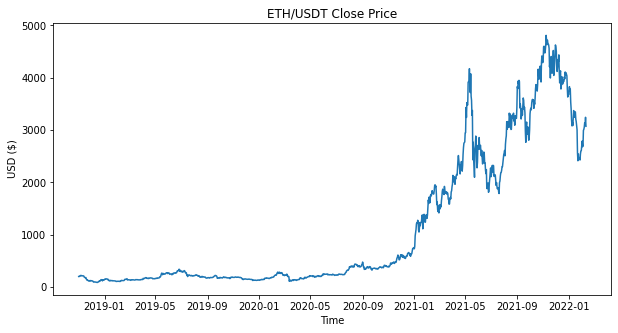

In [9]:
plt.plot(df_ochlv['close'])
plt.title('ETH/USDT Close Price')
plt.xlabel('Time')
plt.ylabel('USD ($)')
plt.show()

# Calculate Moving Averages

Setting up variables for the price used in calculations and the range of periods moving averages are calculated over.

In [10]:
# Column to calculate moving averages on
price_col = 'close'

# Moving Average period ranges
periods = [10, 20, 50, 100, 200]

## Moving Average Calculation

Using pandas rolling and ewm functions to calculate Simple Moving Averages and Exponential Moving Averages for the prices.

In [11]:
for i in periods:
  # SMA Calculation
  df_ochlv['SMA_'+str(i)] = df_ochlv[price_col].rolling(i).mean()

  # EMA Calculation
  df_ochlv['EMA_'+str(i)] = df_ochlv[price_col].ewm(span=i, adjust = False).mean()

# Remove unnecessary dates
df_ochlv = df_ochlv[df_ochlv.index > datetime.date(2019, 12, 31)]

# View dataframe
df_ochlv.head()

,open,close,min,max,volume,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,SMA_100,EMA_100,SMA_200,EMA_200
timestamp,,,,,,,,,,,,,,,
2020-01-01,129.215,130.703,128.728,132.977,223448.2926,128.6767,130.068627,130.93700,132.796658,146.75990,144.869929,162.93280,160.024746,194.881615,174.716122
2020-01-02,130.734,127.170,126.428,130.756,219423.9557,128.6075,129.541604,130.05700,132.260786,145.54198,144.175814,162.54612,159.374157,194.177295,174.243026
2020-01-03,127.153,134.356,125.800,135.144,365424.1440,129.2710,130.416949,129.68275,132.460330,144.53164,143.790724,162.18950,158.878748,193.481945,173.846140
2020-01-04,134.415,134.196,132.531,135.828,365857.7254,130.1840,131.104049,129.26725,132.625632,143.61408,143.414460,161.87310,158.389980,192.829635,173.451611
2020-01-05,134.210,135.400,134.210,138.169,234735.3492,131.1609,131.885131,129.40095,132.889857,142.67720,143.100167,161.49087,157.934733,192.164925,173.072988


## Plot Simple Moving Average

Across the range of periods, we plot the SMA curves against the prices of ETH.

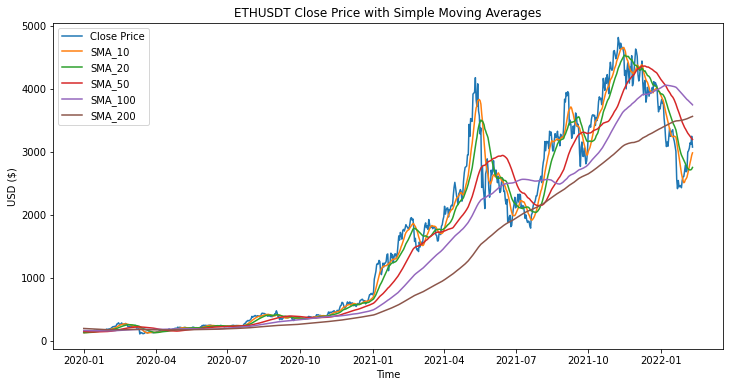

In [12]:
sma_cols = [col for col in df_ochlv if col.startswith('SMA_')]

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_ochlv[[price_col] + sma_cols])
plt.title('ETHUSDT Close Price with Simple Moving Averages')
plt.xlabel('Time')
plt.ylabel('USD ($)')
plt.legend(['Close Price']+sma_cols)
plt.show()

We can notice some interesting points as we plot our graph:

- As the period of the SMA increases, the curves get flatter
- Longer periods of SMAs are less receptive to the peaks and troughs of pricing
- We can see how the shorter SMAs are better at picking up the rises and dips, the longer ones are better at indicating the general trend of the cryptocurrency.

## Plot Exponential Moving Averages

Similarly the EMA curve is plotted against the prices of the cryptocurrency.

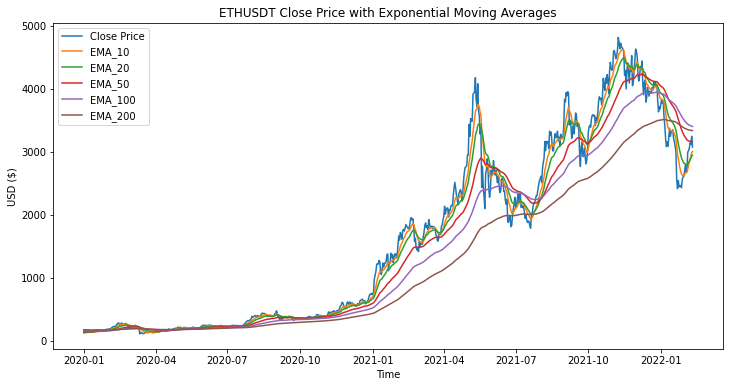

In [13]:
ema_cols = [col for col in df_ochlv if col.startswith('EMA_')]

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_ochlv[[price_col] + ema_cols])
plt.title('ETHUSDT Close Price with Exponential Moving Averages')
plt.xlabel('Time')
plt.ylabel('USD ($)')
plt.legend(['Close Price'] + ema_cols)
plt.show()

Our EMA plot has some interesting findings as well:
- The EMA plot on the first glance looks pretty similar to what SMA shows us.
- However, we can see that the EMA is quicker to pick up changes in the price which can be explained by the exponential weighting process.

# Generate Trade Signals

Strategy: 

- For our generation of trading signals, I used a simple and common strategy which uses crossovers of the moving averages.
- I took into consideration two moving averages: one which is slower (longer period) and a faster one (shorter period). 
- When the faster moving average crosses over the slower one, a buy signal is generated.
- Vice versa, when the slower moving averages crosses over the faster one, a sell signal is generated.

## Helper Functions

In [14]:
# Add columns to dataframe for signals and the crossovers
def signal_crossover(df, fast_col, slow_col):

  # Generate signal (1 -> Hold, 0 -> Not hold)
  df['SMA_Signal'] = np.where(df[fast_col] > df[slow_col], 1.0, 0.0)

  # Calculate points of crossover
  # Diff contains the points where the MAs cross over with a 1/-1 indicating a buy/sell
  df['SMA_Diff'] = df['SMA_Signal'].diff()

  return df

In [15]:
# Plot chart for signals against price
def plot_signal_chart(df, fast_col, slow_col):
  # Plot with signals to buy and sell
  plt.rcParams["figure.figsize"] = (12,6)

  plt.plot(df[[price_col, fast_col, slow_col]])
  plt.title(f"ETHUSDT Close Price with {fast_col} vs {slow_col} Crossover")
  plt.xlabel('Time')
  plt.ylabel('USD ($)')
  # Buy signals
  plt.plot(df[df['SMA_Diff'] == 1].index, 
          df[fast_col][df['SMA_Diff'] == 1], 
          '^', markersize = 15, color = 'g', label = 'buy')
  # Sell signals
  plt.plot(df[df['SMA_Diff'] == -1].index, 
          df[fast_col][df['SMA_Diff'] == -1], 
          'v', markersize = 15, color = 'r', label = 'sell')
  plt.legend(['Close Price', fast_col, slow_col, 'Buy', 'Sell'])
  plt.grid()
  plt.show()

A backtest function is created, that takes a starting amount of capital and evaluates how it would perform on the market. The trading strategy followed incorporates the follows:

- Start with a fixed capital and 0 cryptocurrency
- Every time a buy signal is generated, use all funds to purchase the cryptocurrency at the close price
- Every time a sell signal is generated, sell all holding cryptocurrency at the close price
- Do not buy if no funds are available
- Do not sell if no cryptocurrency is held
- At present day, if cryptocurrency is held, sell it and clear position (Marked as unrealized capital/return)

In [16]:
# Backtest to compare our strategy against the period of data
def backtest(df, start_capital, log = True):

  # Set amount of starting capital and value of ETH available
  capital = start_capital
  eth = 0.0

  num_trades = 0
  real_ret = 0.0
  unreal_ret = 0.0

  # Iterate through df and buy and sell all of the available amount at close price
  for index, row in df[df['SMA_Diff'].isin([1, -1])].iterrows():
    num_trades = num_trades + 1
    if(row['SMA_Diff'] == 1):
      eth = eth + capital/row[price_col]
      if(log):
        print(f"...Buying {capital/row[price_col]:.3f} eth at {row[price_col]:.3f}")
      capital = 0
    else:
      capital = capital + eth*row[price_col]
      if(log):
        print(f"..Selling {eth:.3f} eth at {row[price_col]:.3f}")
      eth = 0

  if(capital > 0):
    real_ret = ((float(capital)/float(start_capital))-1)*100
  if(eth > 0):
    unreal_ret = ((float(eth*df.iloc[-1][price_col])/float(start_capital))-1)*100
  if(log):
    print(f"Final capital: {capital: .3f}, Return = {real_ret: .3f}%")
    print(f"Unrealized capital: {(eth*df.iloc[-1][price_col]): .3f}, Return = {unreal_ret: .3f}%")

  return (num_trades, real_ret, unreal_ret, capital, eth)

## Strategy 1: SMA Crossover Strategy

To test our strategy, initially we consider the 20 day and 50 day SMA and consider how it performs.

We then iterate over the different SMA pairs to figure which would be the most optimal.

### Generating signal

In [17]:
df_ochlv = signal_crossover(df_ochlv, 'SMA_20', 'SMA_50')

### Plotting graph

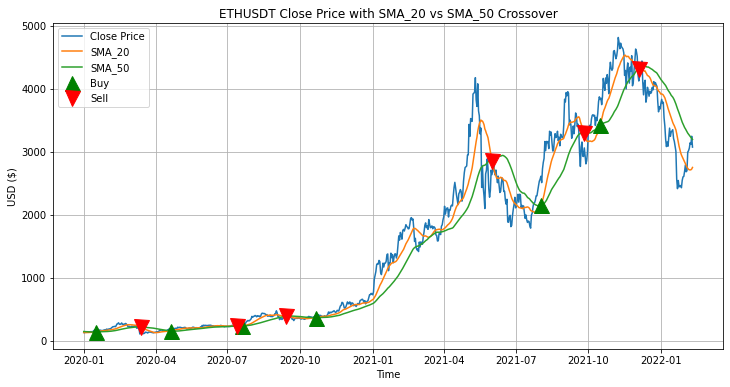

In [18]:
plot_signal_chart(df_ochlv, 'SMA_20', 'SMA_50')

### Backtesting

In [19]:
trades, final_cap, unreal_cap, capital, eth = backtest(df_ochlv, 10000)

...Buying 60.883 eth at 164.250
..Selling 60.883 eth at 134.049
...Buying 47.928 eth at 170.281
..Selling 47.928 eth at 239.736
...Buying 48.677 eth at 236.047
..Selling 48.677 eth at 366.121
...Buying 45.674 eth at 390.198
..Selling 45.674 eth at 2634.525
...Buying 46.118 eth at 2609.122
..Selling 46.118 eth at 2922.199
...Buying 35.212 eth at 3827.351
..Selling 35.212 eth at 4120.176
Final capital:  145078.007, Return =  1350.780%
Unrealized capital:  0.000, Return =  0.000%


From our backtesting, we can see that
- Appropriate buy/sell signals are generated when the trend of the cryptocurrency changes.
- The trade signals lead to a profit making strategy
- As we only consider a scenario where we can buy if we have funds (unlike having the ability to short cryptocurrencies) this strategy seems to be useful in understanding the market and generating revenues.

### Save trade signals to Google Sheets

In [20]:
df_signal = df_ochlv[df_ochlv['SMA_Diff'].isin([1, -1])][['open', 'close', 'min', 'max', 'volume', 'SMA_20', 'SMA_50', 'SMA_Diff']]
df_signal['Signal'] = np.where(df_signal['SMA_Diff'] == 1, 'Buy', 'Sell')
saveToGS(df_signal, 'SMA_20/SMA_50')

### Testing Pairs of SMAs

We move on to iterate over pairs of SMAs to see which of them provide us with the best returns.

In [21]:
capital = 10000

sma_stats = pd.DataFrame(columns = ['# Trades', 'Real. Ret. %', 'Unreal. Ret. %', 'USD ($)', 'ETH'])

for pair in itertools.combinations(sma_cols,2):
  temp_df = df_ochlv.copy()
  temp_df = signal_crossover(temp_df, pair[0], pair[1])
  sma_stats.loc[f"{pair[0]}/{pair[1]}"] = backtest(temp_df, capital, False)

sma_stats.round(2)

,# Trades,Real. Ret. %,Unreal. Ret. %,USD ($),ETH
SMA_10/SMA_20,33.0,0.00,1700.98,0.00,58.64
SMA_10/SMA_50,18.0,1987.58,0.00,208757.74,0.00
SMA_10/SMA_100,8.0,891.60,0.00,99160.12,0.00
SMA_10/SMA_200,6.0,807.09,0.00,90709.42,0.00
SMA_20/SMA_50,12.0,1350.78,0.00,145078.01,0.00
SMA_20/SMA_100,6.0,774.20,0.00,87419.99,0.00
SMA_20/SMA_200,6.0,658.14,0.00,75813.95,0.00
SMA_50/SMA_100,8.0,560.85,0.00,66084.83,0.00
SMA_50/SMA_200,6.0,533.04,0.00,63304.15,0.00
SMA_100/SMA_200,1.0,0.00,1441.08,0.00,50.17


We can see that:

- Our highest return is with the SMA_10/SMA_50 strategy
- The shorter the SMA periods crossed over, the more trades take place
- Barring the extreme outliers, the higher the number of trades, the higher return we can see

## Strategy 2: EMA Crossover Strategy

Similar to our SMA strategy, we repeat the same steps with our EMAs.

In [22]:
df_ochlv = signal_crossover(df_ochlv, 'EMA_20', 'EMA_50')

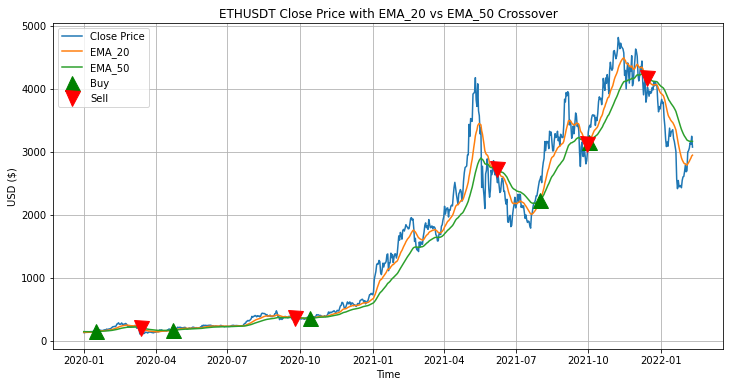

In [23]:
plot_signal_chart(df_ochlv, 'EMA_20', 'EMA_50')

In [24]:
trades, final_cap, unreal_cap, capital, eth = backtest(df_ochlv, 10000)

...Buying 58.853 eth at 169.916
..Selling 58.853 eth at 134.049
...Buying 42.507 eth at 185.594
..Selling 42.507 eth at 351.764
...Buying 39.272 eth at 380.747
..Selling 39.272 eth at 2594.101
...Buying 39.779 eth at 2561.033
..Selling 39.779 eth at 2853.778
...Buying 33.497 eth at 3388.924
..Selling 33.497 eth at 3858.603
Final capital:  129252.941, Return =  1192.529%
Unrealized capital:  0.000, Return =  0.000%


In [25]:
capital = 10000

ema_stats = pd.DataFrame(columns = ['# Trades', 'Real. Ret. %', 'Unreal. Ret. %', 'USD ($)', 'ETH'])

for pair in itertools.combinations(ema_cols,2):
  temp_df = df_ochlv.copy()
  temp_df = signal_crossover(temp_df, pair[0], pair[1])
  ema_stats.loc[f"{pair[0]}/{pair[1]}"] = backtest(temp_df, capital, False)

ema_stats.round(2)

,# Trades,Real. Ret. %,Unreal. Ret. %,USD ($),ETH
EMA_10/EMA_20,21.0,0.00,1660.55,0.00,57.32
EMA_10/EMA_50,10.0,1566.16,0.00,166616.07,0.00
EMA_10/EMA_100,6.0,962.60,0.00,106259.95,0.00
EMA_10/EMA_200,6.0,961.07,0.00,106107.23,0.00
EMA_20/EMA_50,10.0,1192.53,0.00,129252.94,0.00
EMA_20/EMA_100,6.0,932.74,0.00,103273.66,0.00
EMA_20/EMA_200,4.0,890.61,0.00,99061.29,0.00
EMA_50/EMA_100,6.0,610.00,0.00,70999.64,0.00
EMA_50/EMA_200,4.0,506.91,0.00,60691.39,0.00
EMA_100/EMA_200,3.0,0.00,677.61,0.00,25.32


Our EMA return show some interesting findings:

- While they are quite similar to the returns SMAs generated there are some differences.
- The major difference we can see is that our EMA cross over strategy tends to have a higher return than SMA when fewer trades are involved.
- This can be explained by the fact that the exponential weighting is quicker to pick up new sudden rises/dips in the market
- Fewer trades means that we would be less exposed to risk and our positions would be held for longer.
- Thus we can say that in certain aspects, the EMA crossover approach does perform better than the SMA but there is not a definite result.

## Strategy 3: Combining SMA and EMA

To incorporate both together, we can consider pairs of moving averages across both SMAs and EMAs to get an evaluation.

In [26]:
df_ochlv = signal_crossover(df_ochlv, 'EMA_20', 'SMA_20')

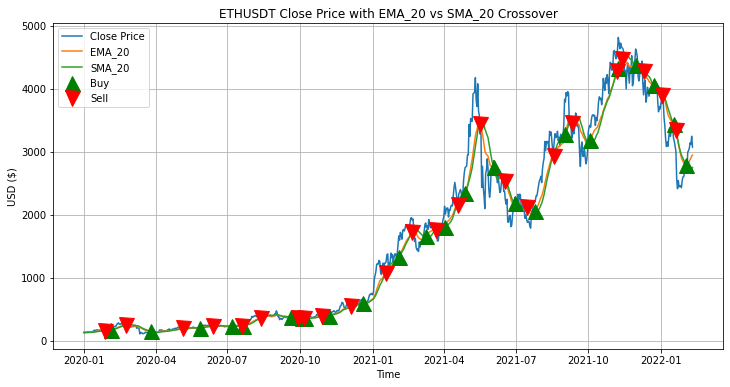

In [27]:
plot_signal_chart(df_ochlv, 'EMA_20', 'SMA_20')

In [28]:
trades, final_cap, unreal_cap, capital, eth = backtest(df_ochlv, 10000)

..Selling 0.000 eth at 175.763
...Buying 49.079 eth at 203.755
..Selling 49.079 eth at 274.420
...Buying 97.260 eth at 138.476
..Selling 97.260 eth at 198.975
...Buying 92.902 eth at 208.309
..Selling 92.902 eth at 238.102
...Buying 92.413 eth at 239.362
..Selling 92.413 eth at 236.047
...Buying 88.833 eth at 245.558
..Selling 88.833 eth at 387.176
...Buying 92.708 eth at 370.993
..Selling 92.708 eth at 353.935
...Buying 93.083 eth at 352.510
..Selling 93.083 eth at 340.885
...Buying 92.849 eth at 341.746
..Selling 92.849 eth at 387.466
...Buying 78.905 eth at 455.936
..Selling 78.905 eth at 596.485
...Buying 73.760 eth at 638.089
..Selling 73.760 eth at 1257.753
...Buying 55.780 eth at 1663.180
..Selling 55.780 eth at 1912.502
...Buying 59.503 eth at 1792.830
..Selling 59.503 eth at 1679.227
...Buying 46.847 eth at 2132.912
..Selling 46.847 eth at 2160.427
...Buying 36.836 eth at 2747.580
..Selling 36.836 eth at 3280.649
...Buying 42.303 eth at 2856.672
..Selling 42.303 eth at 2227.06

In [29]:
capital = 10000

combined_stats = pd.DataFrame(columns = ['# Trades', 'Real. Ret. %', 'Unreal. Ret. %', 'USD ($)', 'ETH'])

for pair in itertools.product(sma_cols, ema_cols, repeat=1):
  if(int(pair[0].split('_')[1]) < int(pair[1].split('_')[1])):
    temp_df = df_ochlv.copy()
    temp_df = signal_crossover(temp_df, pair[0], pair[1])
    combined_stats.loc[f"{pair[0]}/{pair[1]}"] = backtest(temp_df, capital, False)
  elif(int(pair[1].split('_')[1]) < int(pair[0].split('_')[1])):
    temp_df = df_ochlv.copy()
    temp_df = signal_crossover(temp_df, pair[1], pair[0])
    combined_stats.loc[f"{pair[1]}/{pair[0]}"] = backtest(temp_df, capital, False)

combined_stats

,# Trades,Real. Ret. %,Unreal. Ret. %,USD ($),ETH
SMA_10/EMA_20,31.0,0.000000,1713.351527,0.000000,59.039651
SMA_10/EMA_50,12.0,1025.327905,0.000000,112532.790526,0.000000
SMA_10/EMA_100,6.0,1179.302473,0.000000,127930.247314,0.000000
SMA_10/EMA_200,8.0,843.625900,0.000000,94362.590015,0.000000
EMA_10/SMA_20,31.0,0.000000,1568.677965,0.000000,54.329325
SMA_20/EMA_50,12.0,1133.100087,0.000000,123310.008700,0.000000
SMA_20/EMA_100,6.0,800.158180,0.000000,90015.818018,0.000000
SMA_20/EMA_200,4.0,918.501352,0.000000,101850.135189,0.000000
EMA_10/SMA_50,12.0,2002.881229,0.000000,210288.122949,0.000000
EMA_20/SMA_50,14.0,955.036332,0.000000,105503.633244,0.000000


- It appears that some of the strategies combining EMA and SMA outperform the individual ones.
- We can especially see that the EMA_10/SMA_50 seems to have the highest realized returns over the period.
- This can be explained since EMA is better at picking up newer changes as the faster MA whereas SMA equals weights them thus proving a better slow MA.
- We can also see that a hybrid strategy leads to more trades in the cryptocurrency market making us more active.

## Consolidation

Moving on, we compare results across all three strategies.

In [30]:
final_stats = pd.concat([sma_stats, ema_stats, combined_stats])
final_stats.sort_values(by=['Real. Ret. %', 'Unreal. Ret. %', '# Trades'], ascending=False)

,# Trades,Real. Ret. %,Unreal. Ret. %,USD ($),ETH
EMA_10/SMA_50,12.0,2002.881229,0.000000,210288.122949,0.000000
SMA_10/SMA_50,18.0,1987.577408,0.000000,208757.740755,0.000000
EMA_10/EMA_50,10.0,1566.160699,0.000000,166616.069879,0.000000
SMA_20/SMA_50,12.0,1350.780065,0.000000,145078.006544,0.000000
EMA_20/EMA_50,10.0,1192.529405,0.000000,129252.940512,0.000000
SMA_10/EMA_100,6.0,1179.302473,0.000000,127930.247314,0.000000
SMA_20/EMA_50,12.0,1133.100087,0.000000,123310.008700,0.000000
SMA_10/EMA_50,12.0,1025.327905,0.000000,112532.790526,0.000000
EMA_10/SMA_100,6.0,966.712888,0.000000,106671.288844,0.000000
EMA_10/EMA_100,6.0,962.599511,0.000000,106259.951060,0.000000


# Conclusion

- It is interesting to see that most of our better perform strategies involve the shorter periods of returns ( less than 100 days ).
 - Given the high volatility of the cryptocurrency market, it is understandable that longer term averages might not be as effective.

- Moreover, while we saw that EMA was performing better than SMA in some cases it is evident that a hybrid approach using both seems to outperform the individual case for almost all types of periodic pairs.